# Recovering a 2d function from its gradient with a Gaussian Process Regression model

This notebook shows examples on how to use the present gaussian process regression framework to formally integrate functions from derivative observations.

This example will show how to predict a 2D function using gradient observations with both a full GPR and a sparse GPR. The sparse GPR framework works by projecting the training data into a lower dimensional feature space in order to reduce the computational cost (mainly matrix inversions).

## Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [1]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jax.scipy as jsp
from jax.lax import Precision

We will model a forth order polynomial:

In [2]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [3]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 100

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

The GPR framework needs as input for training a tuple of arrays `X_split` of which contains a set of points where the function is sampled and a set of points where the gradient is sampled. Both array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the second array represents the gradient of the function. `Y_train` should just be an array of shape `(n_samples_function + n_samples_gradient,)`.

In [4]:
X_split = [x_func,x_der]

Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

### Defining the Kernel and its initial parameters

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [5]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = jnp.array([2.0, 2.0])

In [6]:
from jaxgp.regression import ExactGPR
from jaxgp.utils import Logger

logger = Logger()

## The sparse GPR model

### Training the sparse GPR model

The `sparseGPR` model can be found in `jaxgp.regression`. The idea of a sparse model is to project your training data into a space with smaller dimension in order to save in computational cost. This is done by projecting your full training set onto a set of reference points via the kernel. 

There are typically 2 methods to choose reference points:
 - choosing a subset of size $m<n$ from the existing datapoints
 - creating an even grid inside the bounds on which the model should be evaluated

Note that below the evenly spread reference grid has fewer points than the subset grid. This was done in order to get a nice even grid which was achieved by taking the largerst perfect square smaller than the number of reference points.

Furthermore we also created a larger set of gradient observations since the predictive power of the sparse model is lower than of the full model. However, this is not a problem computation wise as is seen further below.

In [7]:
from jaxgp.regression import SparseGPR

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 1000

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

logger = Logger()

num_ref_points = (num_d_vals + num_f_vals) // 20
key, subkey = random.split(key)
X_ref_rand = random.permutation(subkey, jnp.vstack((x_der,x_func)))[:num_ref_points]
# this grid has fewer points. It has N points, where N is the largest perfect square smaller than num_ref_points
X_ref_even = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))),jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))))).reshape(2,-1).T

model_rand = SparseGPR(kernel, init_kernel_params, noise, X_ref_rand, logger=None)
model_even = SparseGPR(kernel, init_kernel_params, noise, X_ref_even, logger=None)

In [8]:
X_split = [x_func,x_der]

Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

Looking at the time needed to train the sparse models, even with 10 times as many datapoints the computation is still twice as fast, compare to the full model. This is because the computational effort is roughly 100 times smaller: 
 - The full model needs $\mathcal{O}(N^3)$ flops to train and fit the model
 - The sparse model needs $\mathcal{O}(M^2N + M^3)$ flops to train and fit the model

which comes out to roughly a factor 100 times faster.

In [9]:
# model_rand.train(X_split, Y_train)
model_even.train(X_split, Y_train)

OptStep(params=DeviceArray([2., 2.], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=0))


In [20]:
from jax import vmap
from jaxgp.utils import CovMatrixFD, CovMatrixFF, _build_xT_Ainv_x
from jaxgp.covar import SparseCovarModule

def sparse_covariance_matrix(X_split, Y_data, X_ref, noise, kernel, params):
    KF = CovMatrixFF(X_ref, X_split[0], kernel, params)
    KD = CovMatrixFD(X_ref, X_split[1], kernel, params)
    
    K_MN = jnp.hstack((KF,KD))

    K_ref = CovMatrixFF(X_ref, X_ref, kernel, params)
    # K_ref = K_ref + jnp.eye(*K_ref.shape)*1e-2
        
    func = vmap(lambda v: kernel.eval(v, v, params), in_axes=(0))(X_split[0])
    der = jnp.ravel(vmap(lambda v: jnp.diag(kernel.jac(v, v, params)), in_axes=(0))(X_split[1]))
    full_diag = jnp.hstack((func, der))
    sparse_diag = _build_xT_Ainv_x(K_ref, K_MN.T)
    fitc_diag = (full_diag - sparse_diag) + noise**2

    return SparseCovarModule(K_MN.T, K_ref, fitc_diag)

def sparse_kernelNegativeLogLikelyhood(kernel_params, X_split, Y_data, X_ref, noise, kernel):
    covar_module = sparse_covariance_matrix(X_split, Y_data, X_ref, noise, kernel, kernel_params)

    logdet = covar_module.logdet()

    contraction = covar_module.contract(Y_data, Y_data)

    nlle = 0.5*(logdet + contraction + len(Y_data)*jnp.log(2*jnp.pi))
    
    return nlle

In [12]:
covar_model = model_even.covar_module

mat_model = (covar_model.K_MM + covar_model.K_NM.T@jnp.diag(1 / covar_model.fitc_diag)@covar_model.K_NM)
print(jnp.max(jnp.abs(mat_model-mat_model.T)))
mat_model = (mat_model + mat_model.T) / 2

print(jnp.allclose(mat_model, mat_model.T))
print(jnp.greater(jnp.linalg.eigvals(mat_model),0).all())

print(jnp.linalg.cond(mat_model))

cho, _ = jsp.linalg.cho_factor(mat_model)
cho_rec = jnp.einsum("ji,jk", cho, cho, precision=Precision.HIGHEST)
print(jnp.allclose(mat_model, cho_rec))

0.001953125
True
True
39983244.0
False


In [13]:
covar = sparse_covariance_matrix(X_split, Y_train, X_ref_even, noise, kernel, init_kernel_params)
# print(covar)

In [14]:
mat = (covar.K_MM + covar.K_NM.T@jnp.diag(1 / covar.fitc_diag)@covar.K_NM) #+ jnp.eye(len(covar.K_MM))*1e5
# mat = covar.K_NM.T@jnp.diag(1 / covar.fitc_diag)@covar.K_NM
# mat = covar.K_MM
# mat = covar.K_NM
# mat = jnp.einsum("ij,jk,lk",covar.K_NM.T,jnp.diag(1/covar.fitc_diag),covar.K_NM.T) 
print(jnp.max(jnp.abs(mat-mat.T)))
mat = (mat + mat.T) / 2
# mat = mat@mat.T
# print(jnp.diag(1 / covar.fitc_diag))
# print(covar.K_NM)

print(jnp.allclose(mat, mat.T))
print(jnp.greater(jnp.linalg.eigvals(mat),0).all())

print(jnp.linalg.cond(mat))

cho, _ = jsp.linalg.cho_factor(mat)
cho_rec = jnp.einsum("ji,jk", cho, cho, precision=Precision.HIGHEST)
print(jnp.allclose(mat, cho_rec))

0.001953125
True
True
39983244.0
False


In [21]:
logdet = covar.logdet()
contraction = covar.contract(Y_train,Y_train)
nlle = 0.5*(logdet + contraction + len(Y_train)*jnp.log(2*jnp.pi))
print(nlle)

print(sparse_kernelNegativeLogLikelyhood(init_kernel_params, X_split, Y_train, X_ref_even, noise, kernel))

-3034.0693
-3034.0693


In [16]:
print(jnp.max(jnp.abs(mat-cho_rec)))

0.01171875


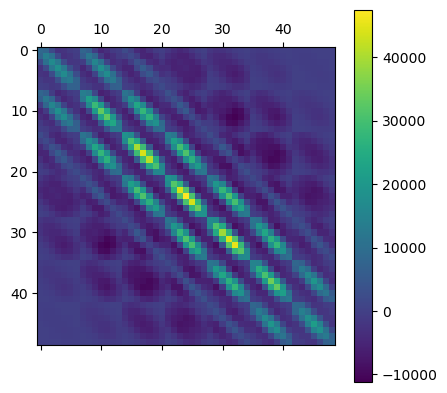

In [17]:
plt.matshow(mat)
plt.colorbar()

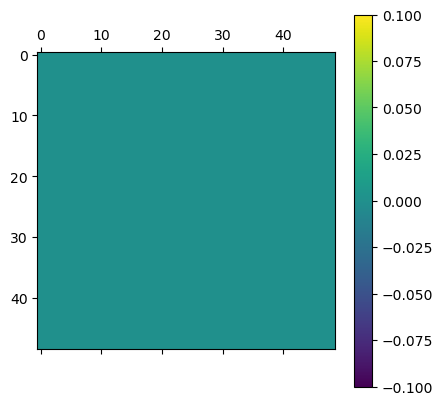

In [19]:
plt.matshow(mat_model-mat)
plt.colorbar()